<a href="https://colab.research.google.com/github/shivendr7/SatGAN/blob/master/EEGAN_train2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

250257408/250242400 [==============================] - 63s 0us/step


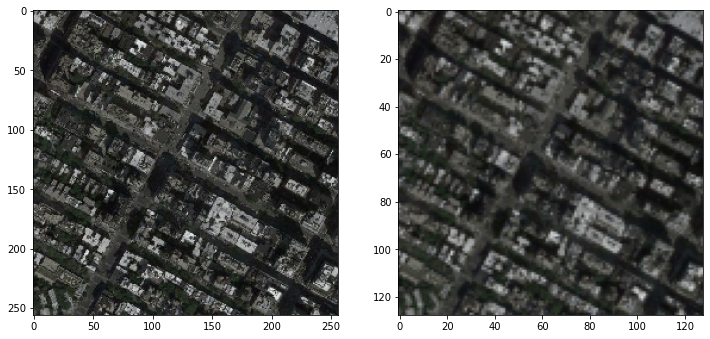

In [ ]:
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.io import read_file
from skimage import data, color
from skimage.transform import resize
url='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
path_to_zip=get_file('maps.tar.gz', origin=url, extract=True)
inside_train=listdir('/root/.keras/datasets/maps/train')
src_list=[]
full_path='/root/.keras/datasets/maps/train/'
for filename in inside_train:
  pixels=load_img(full_path+filename, target_size=(256,512))
  pixels=img_to_array(pixels)
  src_list.append(pixels[:,:256])
src_list=np.asarray(src_list)
resized_list=[]
for i in src_list:
  image=i
  image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                        anti_aliasing=True)
  resized_list.append(image_resized)
resized_list=np.array(resized_list)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(src_list[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(resized_list[0].astype('uint8'))

In [ ]:
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#resized_list=(resized_list-127.5)/127.5
#src_list=(src_list-127.5)/127.5

In [ ]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Concatenate, Lambda, Subtract, Add, Activation, Reshape, Multiply, Flatten, Dropout, Dense, BatchNormalization, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import RandomNormal, Ones
import tensorflow as tf
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
import keras.backend as K
import numpy as np
from keras.models import model_from_json 

In [ ]:
def dense_block(in_layer):
  init=RandomNormal(stddev=0.2)
  conv1=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(in_layer)
  conv11=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv12=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv13=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  concat1=Concatenate()([conv11, conv12, conv13])
  conv201=Concatenate()([concat1, conv11])
  conv202=Concatenate()([concat1, conv12])
  conv203=Concatenate()([concat1, conv13])
  conv21i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv201)
  conv22i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv202)
  conv23i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv203)
  conv21=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv21i)
  conv22=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv22i)
  conv23=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv23i)
  concat2=Concatenate()([conv21, conv22, conv23])
  conv301=Concatenate()([concat2, conv21i])
  conv302=Concatenate()([concat2, conv22i])
  conv303=Concatenate()([concat2, conv23i])
  conv31i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv301)
  conv32i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv302)
  conv33i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv303)
  conv31=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv31i)
  conv32=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv32i)
  conv33=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv33i)
  concat3=Concatenate()([conv31, conv32, conv33])
  conv401=Concatenate()([concat3, conv31i])
  conv402=Concatenate()([concat3, conv32i])
  conv403=Concatenate()([concat3, conv33i])
  conv41i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv401)
  conv42i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv402)
  conv43i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv403)
  concat4=Concatenate()([conv41i, conv42i, conv43i])
  out_layer=Concatenate()([concat4, conv1])
  return out_layer

In [ ]:
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

In [ ]:
def build_subpixel_model(image_shape=(128, 128, 3)):
  mape=MeanAbsolutePercentageError()

  inp=Input(shape=image_shape)
  conv1=Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', kernel_initializer='he_uniform')(inp)
  conv1=Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv1)
  conv1=Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv1)
  conv1=Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv1)
  conv1=Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv1)
  conv1=Conv2D(12, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv1)
  out=SubpixelConv2D(conv1.shape, scale=2)(conv1)
  model=Model(inputs=inp, outputs=out)
  model.compile(optimizer='adam', loss=['mse', mape])
  return model

def build_charb_subpix_model(image_shape=(128, 128, 3)):
  mape=MeanAbsolutePercentageError()

  inp=Input(shape=image_shape)
  Ibase=subpix_model(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.05, beta_1=0.01, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model

In [ ]:
subpix_model=build_subpixel_model()
#charb_subpix=build_charb_subpix_model()

def build_cons_subpix_model(image_shape=(256, 256, 3)):
  inp=Input(shape=image_shape)
  ISR=eesn(inp)
  model=Model(inputs=inp, outputs=ISR)
  opt=Adam(learning_rate=0.00005, beta_1=0.01, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model

cons_subpix=build_cons_subpix_model()

def train_subpixel_model(n_batch):
  ix=np.random.randint(0, 1095, n_batch)
  LR_batch=resized_list[ix]
  HR_batch=src_list[ix]
  loss= subpix_model.train_on_batch(LR_batch, HR_batch)

  #ground_feat=vgg(HR_batch)
  
  #charb_loss=charb_subpix.train_on_batch(LR_batch, ground_feat)
  Ibase=subpix_model(LR_batch)
  cons_loss=cons_subpix.train_on_batch(Ibase, HR_batch)

  return loss, cons_loss#, charb_loss

In [ ]:
for i in range(2000): print(i+1, train_subpixel_model(1))

1 (317.7012939453125, 1837.1171875)
2 (195.17318725585938, 1035.4578857421875)
3 (383.68255615234375, 1495.26025390625)
4 (307.9204406738281, 1428.09912109375)
5 (159.3218231201172, 767.8192138671875)
6 (50.73011779785156, 228.31314086914062)
7 (146.9952850341797, 667.2822875976562)
8 (200.4049835205078, 992.8267822265625)
9 (356.18280029296875, 1867.395751953125)
10 (231.94740295410156, 1162.787841796875)
11 (155.2662353515625, 684.6367797851562)
12 (8.378820419311523, 46.638980865478516)
13 (53.057151794433594, 216.48440551757812)
14 (51.62287139892578, 191.9501190185547)
15 (253.98501586914062, 1337.446044921875)
16 (289.5957946777344, 1128.037841796875)
17 (188.16586303710938, 977.973876953125)
18 (327.64239501953125, 1316.6190185546875)
19 (536.5971069335938, 2266.78857421875)
20 (271.40814208984375, 1271.151123046875)
21 (10.644472122192383, 53.67414474487305)
22 (540.9911499023438, 2569.90771484375)
23 (344.62249755859375, 1423.8896484375)
24 (297.005126953125, 1357.168212890625

Text(0.5, 1.0, 'IHR(256x256)')

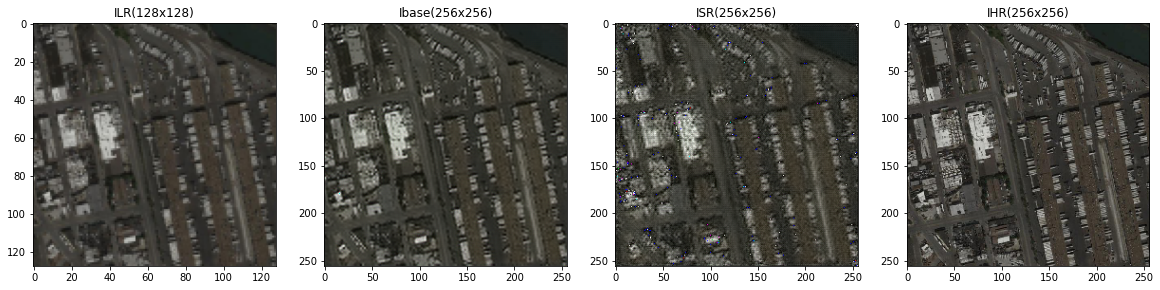

In [ ]:
i=np.random.randint(0, 1096, 1)
out=subpix_model.predict(resized_list[i])
ISR=eesn(out)

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow((resized_list[i]).reshape(128,128,3).astype('uint8'))
plt.title('ILR(128x128)')
plt.subplot(1,4,2)
plt.imshow((out).reshape(256,256,3).astype('uint8'))
plt.title('Ibase(256x256)')
plt.subplot(1,4,3)
plt.imshow(np.array(ISR[0]).astype('uint8'))
plt.title('ISR(256x256)')
plt.subplot(1,4,4)
plt.imshow((src_list[i]).reshape(256,256,3).astype('uint8'))
plt.title('IHR(256x256)')

In [ ]:
def build_udsn(image_shape):
  inp=Input(shape=image_shape)
  db1=dense_block(inp)
  con=Concatenate()([db1, db1])
  db2=dense_block(con)
  con=Concatenate()([db1, db2, db2])
  db3=dense_block(con)
  con=Concatenate()([db1, db2, db3, db3])
  db4=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db4])
  db5=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db5, db5])
  db6=dense_block(con)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(db6)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  LR=Conv2D(filters=12, kernel_size=(3,3), padding='same')(sub_net)
  LR=LeakyReLU(alpha=0.02)(LR)
  Ibase=SubpixelConv2D(LR.shape, scale=2)(LR)
  Ibase=BatchNormalization(momentum=0.8)(Ibase)
  Ibase=Activation('tanh')(Ibase)
  model=Model(inputs=inp, outputs=Ibase)
  return model

In [ ]:
#eesn essentials
def meanfilter(shape, dtype=None):   #kernel to find mean of 3-channel pixel data
  f=np.array([
              [[[.3333],
                [.3333],
                [.33333]]]
  ])
  return K.variable(f, dtype='float32')
def laplacian(shape, dtype=None):   #laplacian kernel
  f=np.array([
      [[[-1]],[[-1]],[[-1]]],
      [[[-1]],[[ 8]],[[-1]]],
      [[[-1]],[[-1]],[[-1]]]
  ])
  return K.variable(f, dtype='float32')
def channel_thrice(shape, dtype=None):   #kernel to triplicate the single channel data
  f=np.array([
              [[[1, 1, 1]]]   #3 for three layers of filters
  ])
  return K.variable(f, dtype='float32')

In [ ]:
def build_eesn(Ibase_shape):
  inp=Input(shape=(Ibase_shape))
  bw=Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer=meanfilter, trainable=False)(inp)  #no change recommended   
  Iedge=Conv2D(filters=1, kernel_size=(3,3), padding='same', kernel_initializer=laplacian, trainable=False)(bw)     #no change recommended
  Itrip=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Iedge)   #no change recommended
  
  sub=Subtract()([inp, Itrip])
  ee=Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))(Iedge)
  ee=Conv2D(filters=64, kernel_size=(3,3), padding='same')(ee)
  ee=Conv2D(filters=16, kernel_size=(1,1), padding='same')(ee)
  
  #dense net
  db=dense_block(ee)
  db=dense_block(db)
  db=dense_block(db)
  db=Conv2D(16, kernel_size=(3,3), padding='same')(db)

  #mask branch
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(ee)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Conv2D(filters=32, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Activation('sigmoid')(mb)

  #transpose=Permute((2,1,3), input_shape=db.shape)(db)
  product=Multiply()([db, mb])  #multiplies element wise
  #con=Concatenate()([mb, db])
  #transpose2=Permute((2,1,3), input_shape=product.shape)(product)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(product)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  ee=Conv2D(4, kernel_size=(3,3), padding='same')(sub_net)
  Istedge=SubpixelConv2D(ee.shape, scale=2)(ee)
  #Istedge=Conv2D(1, kernel_size=(3,3), padding='same')(Istedge)
  Istedge=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Istedge)  #no change recommended
  
  #Istedge=BatchNormalization()(Istedge)
  SR=Add()([Istedge, sub])
  #SR=BatchNormalization()(SR)
  #SR=Activation('tanh')(SR)
  
  model=Model(inputs=inp, outputs=SR)
  return model

In [ ]:
def consistency_loss(y_true, y_pred):
  lambd=5
  return charbonnier_penalty(y_true, y_pred)

mape=MeanAbsolutePercentageError()
def consistency_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  model=Model(inputs=inp, outputs=ISR)
  opt=Adam(learning_rate=0.0005, beta_1=0.01)
  model.compile(loss='mse', optimizer=opt)
  return model

In [ ]:
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)/10
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.0005, beta_1=0.01, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model

In [ ]:
def build_discriminator(img_shape):
  def block(Input, k, n, s):
    l1=Conv2D(n, kernel_size=(k,k), strides=(s,s), padding='same')(Input)
    Bn=BatchNormalization()(l1)
    Lrlu=LeakyReLU(alpha=0.02)(Bn)
    return Lrlu
  I1=Input(shape=img_shape)
  c1=Conv2D(64, kernel_size=(3,3), padding='same')(I1)
  l1=LeakyReLU(alpha=0.02)(c1)
  b1=block(l1, 3, 64, 2)
  b2=block(b1, 3, 128, 1)
  b3=block(b2, 3, 128, 2)
  b4=block(b3, 3, 256, 1)
  b5=block(b4, 3, 256, 2)
  b6=block(b5, 3, 512, 2)
  b7=block(b6, 3, 512, 2)
  b8=Flatten()(b7)
  b9=Dropout(.1)(b8)
  l8=Dense(1024)(b9)
  b10=Dropout(.025)(l8)
  l9=LeakyReLU(alpha=0.02)(b10)
  l10=Dense(1, activation='sigmoid')(l9)
  m=Model(inputs=I1, outputs=l10)
  opt=Adam(learning_rate=0.000002, beta_1=0.5, clipnorm=1) #+1z  b(0.5to 0.01)
  m.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return m

In [ ]:
def build_gan(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  out=disc(ISR)
  disc.trainable=False
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.00002, beta_1=0.1, clipnorm=1)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
udsn=build_udsn(image_shape=(128,128,3))
#plot_model(udsn)

In [ ]:
eesn=build_eesn(Ibase_shape=(256,256,3))
#plot_model(eesn)

In [ ]:
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()

In [ ]:
cons_model=consistency_model(img_shape=(128,128,3))
#cons_model.summary()

In [ ]:
disc=build_discriminator(img_shape=(256,256,3))
#disc.summary()

In [ ]:
gan=build_gan(img_shape=(128,128,3))
#gan.summary()

In [ ]:
def generate_real_samples(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  HR_batch=src_list[ix]
  y_real=np.ones(shape=(n_batch,))
  return HR_batch, y_real

def generate_fake_samples(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  LR_batch=resized_list[ix]
  HR_batch_fake=eesn(udsn(LR_batch))
  y_fake=np.zeros(shape=(n_batch,))
  return HR_batch_fake, y_fake

In [ ]:
#changed

def cons_model2(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  model=Model(inputs=inp, outputs=Ibase)
  opt=Adam(learning_rate=0.0005, beta_1=0.01)
  model.compile(loss='mse', optimizer=opt)
  return model

cons2=cons_model2(img_shape= (128, 128, 3))

In [ ]:
def charb2_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(ISR*127.5+127.5)/10
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.0005, beta_1=0.01, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model

charb2=charb2_model(img_shape= (128, 128, 3))

In [ ]:
#changed

def train_robust_models(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]

  cons2loss=cons2.train_on_batch(input_batch, HR_batch)
  consloss=cons_model.train_on_batch(input_batch, HR_batch)

  HR_batch=HR_batch*127.5+127.5
  ground_feat=vgg(HR_batch)/10
  
  charbloss=charb.train_on_batch(input_batch, ground_feat)
  charb2loss=charb2.train_on_batch(input_batch, ground_feat)

  return consloss, charbloss, cons2loss, charb2loss

In [ ]:
def train(n_epochs=20, n_batch=2):
  half_batch=n_batch//2
  for i in range(n_epochs):
    ix=np.random.randint(0, 1096, n_batch)
    LR_batch=resized_list[ix]
    HR_batch=src_list[ix]
    
    #charb_loss, cons_loss=0, 0
    #charb_loss, charb_acc=train_charbonnier_model(half_batch)
    #cons_loss, cons_acc=train_consistency_model(half_batch)

    #cons2_loss = train_consistency_model2(half_batch)  #changed

    cons_loss, charb_loss, cons2_loss, charb2_loss = train_robust_models(healf_batch)   

    real_batch, y_real=generate_real_samples(half_batch)
    fake_batch, y_fake=generate_fake_samples(half_batch)

    disc_loss_real, disc_acc_real=disc.train_on_batch(real_batch, y_real)
    disc_loss_fake, disc_acc_fake=disc.train_on_batch(fake_batch, y_fake)

    false_positives=np.ones(shape=(n_batch,))
    gan_loss, gan_acc= gan.train_on_batch(LR_batch, false_positives)

    print('%d charb_loss[%.6f] cons_loss[%.6f] disc_loss_real[%.6f] disc_loss_fake[%.6f] gan_loss[%.6f]'%(i+1, charb_loss, cons_loss, disc_loss_real, 
                                                                                                          disc_loss_fake, gan_loss))
    print(f'cons2loss={cons2_loss} charb2loss={charb2_loss}')

In [ ]:
#train(1000, 2) 

In [ ]:
for i in range(100):
  print(i+1, train_robust_models(1))

1 (0.09268125891685486, 0.30000776052474976, 0.08298803120851517, 0.3235039710998535)
2 (0.1665777713060379, 1.0390424728393555, 0.1437498778104782, 1.0178475379943848)
3 (0.05587606877088547, 0.4020880460739136, 0.09487538784742355, 0.43317875266075134)
4 (0.11834722757339478, 0.3900861144065857, 0.08379223942756653, 0.5066090226173401)
5 (0.05898405611515045, 0.26549816131591797, 0.0531531497836113, 0.38235247135162354)
6 (0.16002412140369415, 0.603635311126709, 0.10974884033203125, 0.7509106397628784)
7 (0.04926196485757828, 0.3072880506515503, 0.04724642634391785, 0.32673269510269165)
8 (0.0450378879904747, 0.22638219594955444, 0.04678257554769516, 0.2589922547340393)
9 (0.05164002254605293, 0.42800718545913696, 0.032926030457019806, 0.437911719083786)
10 (0.04135278984904289, 0.27413690090179443, 0.050750359892845154, 0.27241426706314087)
11 (0.08432595431804657, 0.43173280358314514, 0.08764328807592392, 0.5013595223426819)
12 (0.05346521735191345, 0.36832794547080994, 0.055901773

In [ ]:
# save the models (EESN, UDSN, DISC)
#13k1 cons2-> (lr=0.00003->0.00002 beta_1=0.05->0.5)

todrive='drive/MyDrive/weights/'
# serialize weights to HDF5
udsn.save_weights(todrive + "udsn24401.h5")

# serialize weights to HDF5
eesn.save_weights(todrive + "eesn24401.h5")

# serialize weights to HDF5
disc.save_weights(todrive + "disc24401.h5")

print("Saved models to disk")

Saved models to disk


In [ ]:
# load the models (EESN, UDSN, DISC)
todrive='drive/MyDrive/weights/'

udsn.load_weights(todrive + "udsn23001.h5")

eesn.load_weights(todrive + "eesn23001.h5")

#disc.load_weights(todrive + "disc11000.h5")

print("Loaded models from disk")

Loaded models from disk


Text(0.5, 1.0, 'IHR')

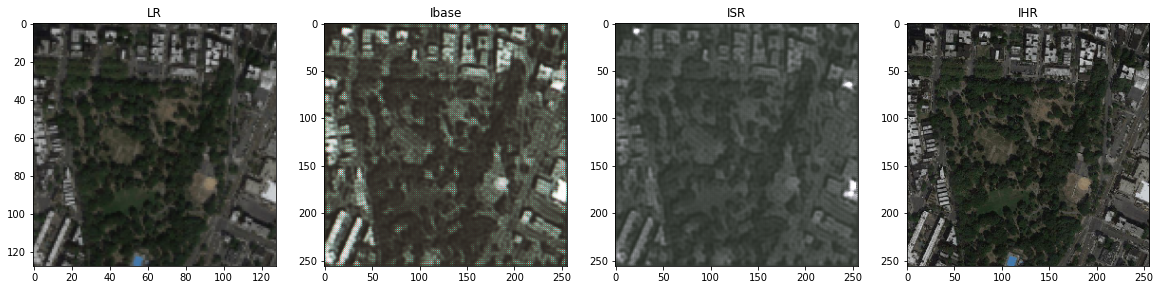

In [ ]:
ix=np.random.randint(0, 1096, 1)
ILR=resized_list[ix]
IHR=src_list[ix]
Ibase=udsn(ILR)
ISR=eesn(Ibase)

plt.figure(figsize=(20, 80))

plt.subplot(1,4,1)
ILR=ILR*127.5+127.5
plt.imshow(ILR.reshape(128,128,3).astype('uint8'))
plt.title('LR')

plt.subplot(1,4,2)
Ibase1=Ibase*127.5+127.5
plt.imshow(np.array(Ibase1).reshape(256,256,3).astype('uint8'))
plt.title('Ibase')

plt.subplot(1,4,3)
ISR1=ISR*127.5+127.5
plt.imshow(np.array(ISR1).reshape(256,256,3).astype('uint8'))
plt.title('ISR')

plt.subplot(1,4,4)
plt.imshow((IHR*127.5+127.5).reshape(256,256,3).astype('uint8'))
plt.title('IHR')

In [ ]:
#vgg(Ibase)

In [ ]:
ISR1

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[109.68803 ,  84.896805,  95.33999 ],
         [110.40704 ,  89.19789 , 104.86593 ],
         [ 95.513466,  79.31865 ,  82.18519 ],
         ...,
         [250.01215 , 249.23389 , 250.27795 ],
         [127.84313 , 115.96049 , 128.07635 ],
         [243.46692 , 238.95538 , 241.95963 ]],

        [[132.28122 , 125.61474 , 132.84859 ],
         [ 99.33808 ,  83.28696 , 106.967575],
         [135.12952 , 136.5762  , 135.67673 ],
         ...,
         [123.04152 , 108.51851 , 131.88998 ],
         [121.255356, 108.84683 , 114.3558  ],
         [126.00871 , 110.72856 , 139.17433 ]],

        [[ 98.774605,  75.963806,  81.392006],
         [ 82.21102 ,  73.2834  ,  81.47412 ],
         [ 87.5979  ,  60.06269 ,  70.4084  ],
         ...,
         [254.91893 , 254.92986 , 254.93031 ],
         [123.58253 , 107.23839 , 122.83076 ],
         [253.94397 , 253.80612 , 253.89972 ]],

        ...,

        [[ 67.68064 ,  70.25607 , 

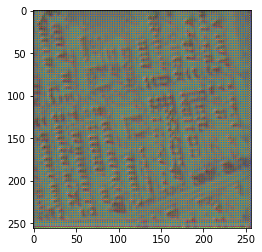

In [ ]:
plt.imshow(np.array(Ibase*127.5+127.5).reshape(256,256,3).astype('uint8'))

In [ ]:
Ibase.shape

TensorShape([1, 256, 256, 3])

140001

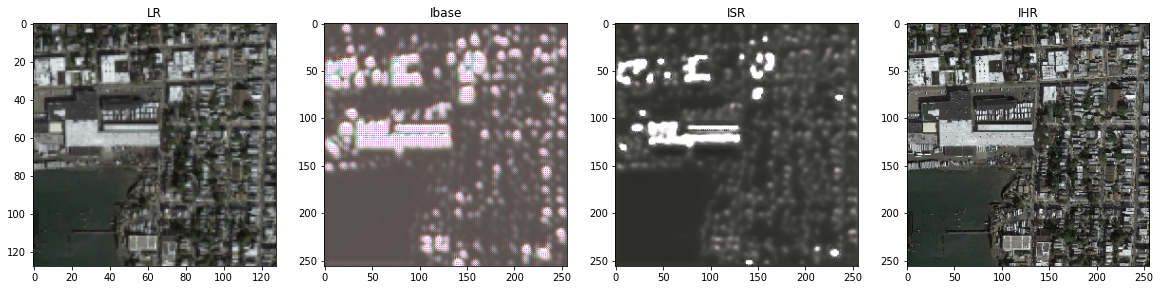